# **Expectation-Maximization algorithm** (hidden model)
### Author: Martí Cortada Garcia
---

In [11]:
# Import required libraries
import numpy as np
from Bio import SeqIO, Phylo
from io import StringIO
from collections import Counter, OrderedDict
import itertools
import pandas as pd
import math
import copy

# Import required functions from modules we have programmed
from data_simulation import simulate

### **Input:**
We have a tree $T$ (where the root corresponds to the internal node codified as `Int_0`) and the alignments of the leaves.

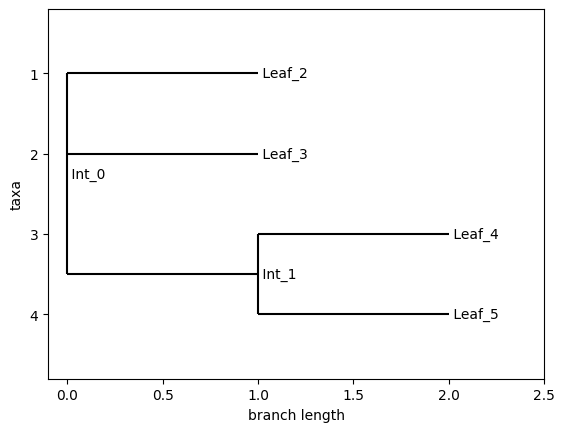

In [12]:
newick_tree = "(2:1,3:1,(4:1,5:1):1)"
tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [3]:
edges, node_distr = simulate(net) # simulate data calling the module data_simulation.py 

# Preprocess leave alignments
leave_alignments = [i for i in SeqIO.parse("test_4_leaves.fasta", "fasta")]
for i in leave_alignments:
    print("Seq>", i.seq)
# Codify the alphabet {A,G,C,T} -> {0,1,2,3}
leave_sequences = []
for i in leave_alignments:
    seq = ""
    for j in i.seq:
        if j == "A":
            seq += "0"
        elif j == "G":
            seq += "1"
        elif j == "C":
            seq += "2"
        elif j == "T":
            seq += "3"
        else:
            raise ValueError("Invalid nucleotide")
    leave_sequences.append(seq)
leave_sequences

Seq> TACGACGATGACGCTCACCTACTTCCAAACGGGGGAAGGTTTCGGAGTCCCCACAACGCGGCTGAATCTTACAGGGGCCTTGAAGGAATCCTTCCAACTACTTCTAGCGTCGACGGGAGGGTGAACTCCTTTTGAAGGGGGGTATCGCAGAGCTGCCATCAGCTCCGCGGTTGACATGACCGCTATGATCCGTGCAGCAGAACGTGAGCGCTATCCCCAAGCACGCAAAACGACGTGGCGTACGCTTCATGCCTAGCACAATACGAGCCAACTATCGCGATATTAAATAGAACGTAAGTCAAGGGCGATTACCAGGTACGCCAACACCCCGTTCTAACACCTATCTCAAGTCGGTAGCAGGTCTCGCAGTCTTAGGCAGACGCCTCCAGTTAGCTTACAGAGAAACTTCGTGAACGATACGGCGCGCCAGATCATCTCGGAACGTTGTTACGACCTCCACTCTGCTCGTAACTAGGATTGGATGGAAGACATATATTATATACTAGTAACGTACAGCGCCGTTTGGGCACAAGACAAACTTCCCGTGCTTGTAATGTATGTGATCGACGAAGGCCCAAACCCTCCCAACCGGTCGTAAGCTAATCTATACCATGTATGTGTCCTTGCATCAACGGTTCTCCAAGATGGGTTTGGACGCCCCACGTGGCCTCGTGCCCCGGGCGCTCCTGATGAACGCTACCTTTGACTTCTTACCCGTCCCACACGATTTCATTCACTATCTGCCCGCATCTGATTCAACGGGTATACAACTACTCGAGTTCAATGGTTTAACTGTCATTTGTTGAAGATTCCAAGCCGACAGGATCGCCCCTAGTGCGGTCCTATCAAAAATGACACGTTTACACTCTTGCATCTCGTACTCTGCTTCAAGTGATTTCAAGCCTGCCGAAGGAATGTCATCGCTATACGCCCATACGCAATTAAGTTTGTCGCAGATGTTTTAGCTAGGGGTACTATCGGAACCTGTAGGTCAT

['30210210310212320223023322000211111001133321101322220200212112310032330201111223310011003223322002302332301213210211101113100232233331001111113032120101231220320123221211331020310221230310322131201201002131012123032222001202120000210213112130212332031223012020030210122002303212103033000301002130013200111210330220113021220020222213323002022303232001321130120113232120132330112010212232201330123302010100023321310021030211212122010320323211002133133021022322023231232130023011033110311001020303033030302301300213020121221333111202001020002332221312331300313031310321021001122200022232220022113213001230032303022031303131322331203200211332322001031113331102122220213112232131222211121232231031002123022333102332330222132220202103332033202303231222120323103320021113030200230232101332003113330023132033313310010332200122102011032122223013121132230320000031020213330202323312032321302323123320013103332001223122100110031320321230302122203021200330013331321201031333301230111130230321100223130113203322

---
## **EM algorithm**

In [25]:
# Auxiliary functions

def init_root_distribution():
    """
    Initialise estimation for the root distribution (all probabilities between 0.2 and 0.3)
    """
    estimated_root_distribution = []
    while True:
        estimated_root_distribution = np.random.dirichlet([1,1,1,1])
        i = 0
        while i<4:
            if estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3:
                i += 1
            else:
                break
        if i == 4:
            assert(np.sum(estimated_root_distribution) < 1.0000001 and np.sum(estimated_root_distribution) > 0.9999999)
            assert(estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3 for i in range(4))
            break
    return estimated_root_distribution

def init_transition_matrix():
    """
    Initialise estimation for the transition matrices (which we estimate as LARGE-DIAGONAL-VALUE matrices)
    """
    M = np.zeros((4,4))
    i=0
    while i<4:
        R = np.random.dirichlet([1,1,1,1])
        if R[i] > 0.6 and R[i] < 0.8:
            M[i,:] = R 
            i = i + 1
    assert (M[i,i] > 0.6 and M[i,i] < 0.8 for i in range(4))
    assert (np.sum(M[i,:]) < 1.0000001 and np.sum(M[i,:]) > 0.9999999 for i in range(4))
    return M

def log_likelihood(states, u_i, param, root_distribution, n_int):
    """Compute the log-likehood of the tree"""
    logL = 0
    for obs in states:
        if obs[n_int:] in u_i:
            p_ij = root_distribution[int(obs[0])] 
            for p in param.items():
                u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
                p_ij *= p[1].transition_matrix[int(obs[u]), int(obs[v])]
            logL += (u_i[obs[n_int:]] * math.log(p_ij))
    return logL

class Param:
    """
    Class to store the parameters of the tree
    """
    def __init__(self, edge, transition_matrix, alignment=None):
        self.edge = edge
        self.transition_matrix = transition_matrix
        self.alignment = alignment # it will only be placed in the leaves

# Obtain number of leaves and internal nodes
n_leaves, n_int = 0, 0 
for node in net.nodes():
    if node.name.startswith("L"):
        n_leaves += 1
    else:
        n_int += 1

# Count all the leaves ocurrences 
sequence_length = len(leave_sequences[0])
number_of_sequences = len(leave_sequences)
occurrences = []
for i in range(sequence_length):
    _ = ''
    for j in range(number_of_sequences):
        _ += leave_sequences[j][i]
    occurrences.append(_)
c = Counter(occurrences)
u_i = OrderedDict(sorted(c.items()))

# Define all possible (hidden) states of the internal nodes 
hidden_combinations = itertools.product([0,1,2,3], repeat=n_int)
sorted_hidden_combinations = sorted(hidden_combinations)
for i in range(len(sorted_hidden_combinations)):
    sorted_hidden_combinations[i] = ''.join([str(s) for s in sorted_hidden_combinations[i]])
 
# Define all possible fully observed states (i.e. combining u_i + internal nodes)
# '000000' would mean to have an 'A' in all nodes: Int_0, Int_1, Leaf_2, Leaf_3, Leaf_4, Leaf_5 
states = list(itertools.product(list(sorted_hidden_combinations), list(u_i.keys())))
states = [i[0]+i[1] for i in states]

############################################################################################################
###################################### STEP 0: Initialise parameters #######################################
############################################################################################################
estimated_root_distribution = init_root_distribution() # First estimation for the root distribution

PARAMS = dict() # Dictionary to store the estimation matrices for each edge
for edge in net.edges():
    # If we are in a leaf, we need to specify the alignment
    iter_leaves = 0
    if edge[1].name.startswith("L"):
        new_edge = Param(edge, init_transition_matrix(), leave_alignments[iter_leaves].seq)
        iter_leaves += 1
    # Otherwise, are in internal nodes
    else:
        new_edge = Param(edge, init_transition_matrix())
    u = str(edge[0].name.split("_")[1])
    v = str(edge[1].name.split("_")[1])
    name = "M_" + u + "_to_" + v
    PARAMS[name] = new_edge

eps = 10**(-3)                  # epsilon for convergence
iter = 0                        # iteration counter 
params = copy.copy(PARAMS)      # copy of the parameters (will be updated at each iteration)
logL = log_likelihood(states, u_i, params, estimated_root_distribution, n_int)
logL_ = 0

while np.abs(logL_ - logL) > eps:
    print(np.abs(logL_ - logL))
    if iter > 0:
        logL = logL_

    ############################################################################################################
    ################################################## E-step ##################################################
    ############################################################################################################
    # Define the expected hidden data matrix
    U = dict()

    for obs in states:
        U[obs] = u_i[obs[n_int:]] # initialise by computing u_i of the expected hidden data matrix formula
        f_ij = estimated_root_distribution[int(obs[0])] 
        for p in params.items():
            u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
            f_ij *= p[1].transition_matrix[int(obs[u]), int(obs[v])]
        # Now f_ij := numerator of the expected hidden data matrix formula 

        # We need to marginalise to obtain f_i := denominator of the expected hidden data matrix formula
        f_i = 0 # we initialise the partial data model
        observed_data = obs[n_int:]
        for state in states:
            if state[n_int:] == observed_data:
                pi = estimated_root_distribution[int(state[0])]
                for p in params.items():
                    u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
                    pi *= p[1].transition_matrix[int(state[u]), int(state[v])]
                f_i += pi
        U[obs] *= f_ij/f_i


    assert(len(U) <= 4**(n_int+n_leaves))
    sum = 0
    sum2 = 0
    for i in U.items():
        sum += i[1]
    for i in u_i.items():
        sum2 += i[1]
    assert(sum < sequence_length+0.001 and sum > sequence_length-0.001)
    assert(sum2 < sequence_length+0.001 and sum2 > sequence_length-0.001)

    ############################################################################################################
    ################################################## M-step ##################################################
    ############################################################################################################
    estimated_parameters = dict()
    root_distr = np.zeros(4)
    iter_root = 0 # counter for the root distribution, we only want to count once

    for p in params.items():
        u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
        name = "M_" + str(u) + "_to_" + str(v)
        estimated_parameters[name] = np.zeros((4,4))
        for i in range(4):
            for j in range(4):
                ui = 0
                for obs in U.items():
                    # For the root distribution, we only need to consider the first internal node
                    if iter_root == 0 and obs[0][0] == str(i):
                        root_distr[i] += obs[1]
                    # For the transition matrices:
                    if obs[0][u] == str(i) and obs[0][v] == str(j):
                        estimated_parameters[name][i][j] += obs[1]
                    if obs[0][u] == str(i):
                        ui += obs[1]
                # Update root distribution
                if iter_root == 0:
                    root_distr[i] /= sequence_length
                iter_root = 1
                estimated_parameters[name][i][j] /= ui
            iter_root = 0
            
        # Update parameters
        params[name].transition_matrix = estimated_parameters[name]

    ############################################################################################################
    ############################ Compute log-likelihood of the estimated parameters ############################
    ############################################################################################################
    logL_ = log_likelihood(states, u_i, params, root_distr, n_int)

    iter += 1

print("Done!")
print("Number of iterations: ", iter)

204486.64286450032
6311.0721221923595
1217.4381625265814
286.01662403321825
90.52076521961135
200.46926370231085
285.06260068618576
289.18216243665665
283.13255525386194
272.7721424915653
253.35093309628428
227.05692701222142
199.03143443076988
172.9828422763967
150.4912254915398
131.77746536253835
116.4540585296927
103.95295466593234
93.7167074502795
85.26611190190306
78.21312437020242
72.25282820151187
67.14932684303494
62.72153474073275
58.83090672001708
55.37151842779713
52.26230269626831
49.44107234815601
46.85995627238299
44.48192869310151
42.27817514791968
40.226095909572905
38.307794328342425
36.50893380708294
34.817875010252465
33.225025923980866
31.722353414574172
30.30301709152991
28.961095569451572
27.691382334654918
26.489233832078753
25.350456612562994
24.271223499265034
23.248011313960887
22.277554421598325
21.356809900607914
20.482931180275045
19.65324780269293
18.865249593916815
18.11657401971752
17.40499577386072
16.728418000857346
16.084864638687577
15.47247361333575

---
## **Felsenstein algorithm**

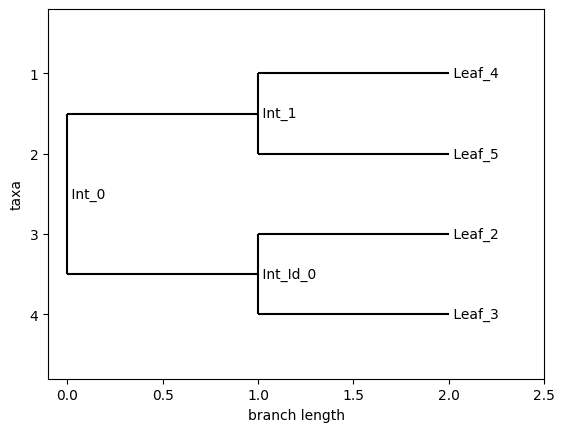

In [39]:
# Felsentstein algorithm
newick_tree = "((4,5),(2,3))"
L_tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(L_tree.get_nonterminals()):
    id = 0
    if idx == 2:
        clade.name = "Int_Id_" + str(id)
        id += 1
    else:
        clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(L_tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(L_tree)

L_net = Phylo.to_networkx(L_tree) # to graph

In [42]:
L_edges = []

for edge in L_net.edges():
    if edge[0].name.split("_")[1] == "Id" and edge[1].name.split("_")[1] == "Id":
        u = str(edge[0].name.split("_")[1]) + "_" + str(edge[0].name.split("_")[2])
        v = str(edge[1].name.split("_")[1]) + "_" + str(edge[1].name.split("_")[2])
    elif edge[0].name.split("_")[1] == "Id" and edge[1].name.split("_")[1] != "Id":
        u = str(edge[0].name.split("_")[1]) + "_" + str(edge[0].name.split("_")[2])
        v = str(edge[1].name.split("_")[1])
    elif edge[0].name.split("_")[1] != "Id" and edge[1].name.split("_")[1] == "Id":
        u = str(edge[0].name.split("_")[1])
        v = str(edge[1].name.split("_")[1]) + "_" + str(edge[1].name.split("_")[2])
    else:
        u = str(edge[0].name.split("_")[1])
        v = str(edge[1].name.split("_")[1])
    L_edges.append((u,v))

# Create a dictionary to store the father and son information
family_tree = {}

# Loop through the edges and update the dictionary
for father, son in L_edges:
    if father not in family_tree:
        family_tree[father] = []
    family_tree[father].append(son)

# Create a DataFrame from the dictionary
tree_df = pd.DataFrame.from_dict(family_tree, orient='index')

# Fill NaN values with empty strings
tree_df = tree_df.fillna('')

# Change column names
tree_df.columns = ['Child_1', 'Child_2']

print(tree_df)

     Child_1 Child_2
0          1    Id_0
1          4       5
Id_0       2       3


In [16]:
######################### DEBUGGING ############################

# # All possible (theoretical) occurrences of nucleotides in the leaves
# alphabet = [0, 1, 2, 3]
# combinations = itertools.product(alphabet, repeat=n_leaves)
# sorted_combinations = sorted(combinations)
# for i in range(len(sorted_combinations)):
#     sorted_combinations[i] = ''.join([str(s) for s in sorted_combinations[i]])

# # All possible (hidden) states of the internal nodes (i.e. indexes of columns of U)
# hidden_combinations = itertools.product(alphabet, repeat=n_int)
# sorted_hidden_combinations = sorted(hidden_combinations)
# for i in range(len(sorted_hidden_combinations)):
#     sorted_hidden_combinations[i] = ''.join([str(s) for s in sorted_hidden_combinations[i]])

# # To check if an element is within a dictionary or not 
# if '0101' in u_i:
#     print('ok')
# else:
#     print('not ok')
# if '0000' in u_i:
#     print('ok')
# else:
#     print('not ok')

In [29]:
# Check the theoretical parameters:
for i in range(len(edges)):
    print("Edge:", edges[i].edge)
    print("Transition matrix:", edges[i].transition_matrix)
    print("---"*30)

print("Root distribution:", node_distr['Int_0'])

Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix: [[0.73831629 0.02720142 0.12774802 0.10673427]
 [0.04513923 0.83580051 0.0625642  0.05649606]
 [0.06128502 0.07611864 0.78428373 0.07831261]
 [0.05410388 0.06094774 0.09021475 0.79473363]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix: [[0.80908786 0.09241689 0.04272486 0.05577039]
 [0.01481988 0.81555816 0.10195746 0.0676645 ]
 [0.06537933 0.06299305 0.7943246  0.07730301]
 [0.11151667 0.08774799 0.07032873 0.73040661]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix: [[0.90609141 0.06416317 0.01920794 0.01053748]
 [0.10690466 0.72074135 0.03536559 0.1369884 ]
 [0.04585663 0.05857391 0.79193656 0.1036329 ]
 [0.04226927 0.06892553 0.14203425 0

In [32]:
# Check the estimated parameters:
for i in params.items():
    print(i[0])
    print("Edge:", i[1].edge)
    print("Transition matrix:\n", i[1].transition_matrix)
    print("---"*30)

print("Root distribution:", root_distr)

M_0_to_2
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix:
 [[0.83660196 0.00761104 0.05542856 0.10035844]
 [0.08930457 0.80530883 0.06363684 0.04174976]
 [0.05595426 0.06902579 0.77499522 0.10002473]
 [0.07524691 0.08202588 0.14275854 0.69996866]]
------------------------------------------------------------------------------------------
M_0_to_3
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix:
 [[0.79403686 0.09763793 0.05476088 0.05356434]
 [0.03903061 0.85081396 0.04417043 0.065985  ]
 [0.10430197 0.0685376  0.76078742 0.06637301]
 [0.14237629 0.08440124 0.1183033  0.65491918]]
------------------------------------------------------------------------------------------
M_0_to_1
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix:
 [[0.94220283 0.04221316 0.00493258 0.01065142]
 [0.14310485 0.68494453 0.0014208  0.17052981]
 [0.06634439 0.0806811  0.80792923 0.04504528]
 [0.04

In [35]:
# Compute the matrix difference between the theoretical and estimated parameters
for i in range(len(edges)):
    print("Edge:", edges[i].edge)
    print("Transition matrix difference:\n", np.abs(edges[i].transition_matrix - params['M_' + str(edges[i].edge[0].name.split("_")[1]) + '_to_' + str(edges[i].edge[1].name.split("_")[1])].transition_matrix))
    print("---"*30)

Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_2'))
Transition matrix difference:
 [[0.09828567 0.01959038 0.07231946 0.00637582]
 [0.04416534 0.03049168 0.00107264 0.0147463 ]
 [0.00533076 0.00709285 0.00928851 0.02171212]
 [0.02114303 0.02107814 0.0525438  0.09476497]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Leaf_3'))
Transition matrix difference:
 [[0.015051   0.00522104 0.01203602 0.00220606]
 [0.02421073 0.0352558  0.05778703 0.0016795 ]
 [0.03892264 0.00554455 0.03353718 0.01093001]
 [0.03085962 0.00334675 0.04797457 0.07548743]]
------------------------------------------------------------------------------------------
Edge: (Clade(name='Int_0'), Clade(branch_length=1.0, name='Int_1'))
Transition matrix difference:
 [[0.03611143 0.02195    0.01427536 0.00011394]
 [0.03620019 0.03579682 0.03394479 0.03354142]
 [0.02048776 0.02210718 0.01599267 0.05858762]
